# Data mining New York Times articles
by Harshini Konduri, Pallavi Damle, Shantanu Saha, Harshvardhan Shukla, Koba Khitalishvili


## Introduction
In our project we explore Natural Language Processing by mining the New York Times articles. The basic idea was to see if it is possible to classify the articles by topic using the article abstracts. By classifying the articles we are able to obtain the most important words for each topic using the feature importances generated by the classifier. Potential use would be for marketing purposes to see what keywords are trending for a given topic. 

We are using open source tools like machine learning python library Scikit-learn and Beautiful soup for web scraping. We are proponents of reproducible research and you can find all our code at https://github.com/KobaKhit/Data-mining-using-NLP .

## Results
### Data preparation
Initially, we wrote a python script that scraped new york times articles for information like date published, author, and most importantly the body of text. However, some articles are private and cannot be scraped. Additionally, the webscraping was slow. As a result, we wrote a different script ,`nytsnippetgetter.py`, that sends direct http search request to the www.nytimes.com/ server and gets a `json` response instantly. Instead of the body of text we get a snippet which can be the first leading paragraph, a summary, or an abstract. We were able to obtain 36 thousand article abstracts and other information in less than 5 minutes. After preprocessing the raw text data and obtaining the TFxIDF statistics for each word across all articles we use the multinomial Naive Bayes model for classification. 

### Classification
You can see in appendix that our model has 100% accuracy on test data when classifying by article topic which basically means that the New York Times search engine is efficient. However, when classifying articles from different time periods by author the accuracy of the model is only 0.8. In every instance we provide the most important words by topic (author).

So far we found out that New York Times has a superb search engine and that authors from distinct time periods had different vocabularly which is sort of obvious. At this point we are continueing our reserch in several directions. 

We look at comparing word clouds at different time points and how vocabularly changed with time. We have access to articles dating as early as 1921. To do so we decided to use the Topic modelling by latent Dirichlet allocation. There is an implimentation of the algorithm for python called the `lda` package. However, scikit-learn has an implementation of the same algorithm as well ([sklearn.decomposition.LatentDirichletAllocation](http://scikit-learn.org/dev/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)). We were inspired by Blei's approach of topic modelling (2012).

We also want to test whether its possible  to classify articles obtained from different news sources using NY Times articles as training data. 


## Conclusion
Going forward we want to focus on data preprocessing. Namely, edit the corpus of the articles and remove redundant words like prepositions. In this way we will be able to capture most important words by topic. According to Blei, efficient topic modeling increases the relevance and flexibility of any text data search results. 

Additionaly, we would like to make use of other classifiers like RandomForest and Support vector machines and maybe an ensemble method.

## References 

  - Blei, David. Probabilistic Topic Models. *Communications of the ACM*. April 2012. vol. 55. no. 4
  
## Works Consulted
  
  - [A topic model for movie reviews](http://cpsievert.github.io/LDAvis/reviews/reviews.html)
  - [LDAvis R Intro](https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf)
  - [LDAvis Python example](http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb#topic=5&lambda=0.2&term=)
  
## Appendix

In [1]:
from nytsnippetgetter import get_data
import time, os.path, json, re

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

# start timer
start_time = time.time()

# get available number of pages for each topic. Each page is equivalent to 10 articles
topics=['economics','politics','espionage','global+warming', 'donald+trump','hillary+clinton', 
        'bernie+sanders', 'guns', 'cancer', 'sex']
ndocs = [500]
# topics=['economics','politics']
get_data(topics, BEGINDATE = 20131213, LIMITS=True) # articles written since 2013-December-13

Total number of articles available:  64685
Date range:  20160530 -> 20131213 

economics :  4760
politics :  19921
espionage :  1206
global+warming :  2109
donald+trump :  5657
hillary+clinton :  6218
bernie+sanders :  2897
guns :  3497
cancer :  7970
sex :  10450


In [2]:
if os.path.isfile("../scripts/2016-05-31-diff-topics.json"):
    # load saved data
    with open('../scripts/2016-05-31-diff-topics.json') as json_data:
        articles = json.load(json_data)["data"]
    print("Loaded " + str(len(articles)) + " articles.")
else:
    # download article data 
    # articles = get_data(TOPICS = topics, NPAGES = npages, BEGINDATE = 20131213)
    articles = get_data(topics, ndocs, BEGINDATE=20140101, FILENAME='example.json')
    # articles = get_data(TOPICS = topics, BEGINDATE = 20131213, NPAGES = [15,10])

Loaded 12200 articles.


In [3]:
# articles is a list of objects with each object being one document
articles[0]

{'abstract': None,
 'author': 'MANJULA VARGHESE and MATT A.V. CHABAN',
 'date_modified': '2016-05-31T11:43:58Z',
 'date_published': '2016-05-30T18:42:36Z',
 'keywords': [{'is_major': 'N',
   'name': 'glocations',
   'rank': '1',
   'value': 'Manhattan (NYC)'},
  {'is_major': 'N', 'name': 'subject', 'rank': '2', 'value': 'Art'},
  {'is_major': 'N',
   'name': 'subject',
   'rank': '3',
   'value': 'Appraisals and Valuation (Property)'},
  {'is_major': 'N',
   'name': 'subject',
   'rank': '4',
   'value': 'Gentrification'}],
 'lead_paragraph': 'Artists who work in the city share their thoughts about how their practice is affected by the space they work in and the city’s gentrification.',
 'nytclass': None,
 'section_name': {'content': 'realestate',
  'display_name': 'Real Estate',
  'url': 'http://www.nytimes.com/pages/realestate/index.html'},
 'snippet': 'Artists who work in the city share their thoughts about how their practice is affected by the <strong>space</strong> they work in an

In [4]:
# retain unique articles
unique_articles = []
for i in articles:
    if i['snippet'] not in [x['snippet'] for x in unique_articles]: 
        unique_articles.append(i)
        
# some articles are missing lead paragraph and abstract. just use snippets for now
# data = [re.sub(r'(<.*>)','',x['snippet']) for x in unique_articles if x['user_topic'] in 
#         ['donald+trump','hillary+clinton', 'bernie+sanders', 'ted+cruz']]
data = [re.sub(r'(<.*>)','',x['snippet']) for x in unique_articles]
words = set([ y for x in unique_articles for y in x['snippet'].split(" ")])

# show html tags
[x for x in words if "<" in x][0:5]

['low-<strong>tech</strong>',
 '<strong>sports</strong>-oriented',
 'money-in-<strong>politics</strong>',
 '<strong>Tech</strong>.',
 '<strong>space</strong>:']

In [5]:
# number of articles
print("N articles: ", len(articles))
print("N unique articles: ", len(unique_articles))
print("N unique words: ", len(set([ y for x in data for y in x.split(" ")])))

# words
[y for x in data for y in x.split(" ")][0:5]

N articles:  12200
N unique articles:  6916
N unique words:  38644


['Artists', 'who', 'work', 'in', 'the']

In [6]:
# https://pypi.python.org/pypi/lda
# http://stackoverflow.com/questions/20984841/topic-distribution-how-do-we-see-which-document-belong-to-which-topic-after-doi
# stoplist = set('for a of the and to in'.split())
# data = [[word for word in document.lower().split() if word not in stoplist]
#          for document in documents]

# check if data has Nones
nonesidx = [data.index(x) for x in data if x == None and len(x) > 0]
if len(nonesidx) > 0:
    print("You have nones. Below are indices of articles.")
    print(nonesidx)
else:
    print("No Nones. Good to go.")
    
data[0:3]

No Nones. Good to go.


['Artists who work in the city share their thoughts about how their practice is affected by the  they work in and the city’s gentrification.',
 'wonder when the finish will come. This time, Truex was surprised at how quickly the laps passed and how he found all that open . Not everything was perfect: Truex had a mid-race wobble that NASCAR greats turned TV analysts',
 'points out, craning her head back to point out another work, done in grease pencil and featuring the creative use of white  and shading to give it almost a two-dimensional effect. "That\'s actually a style that graffiti writers']

In [7]:
# article topics
# label = [ x['user_topic'] for x in unique_articles if x['user_topic'] in 
#         ['donald+trump','hillary+clinton', 'bernie+sanders', 'ted+cruz']]

label = [ x['user_topic'] for x in unique_articles]
classes = list(set(label))
label[-5:-1]

['stocks', 'stocks', 'stocks', 'stocks']

In [8]:
classes

['stocks', 'tech', 'sports', 'politics', 'space']

In [9]:
# http://scikit-learn.org/stable/datasets/twenty_newsgroups.html

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

# Convert raw documents to a matrix of TF-IDF features.
vectorizer = TfidfVectorizer(stop_words = "english", ngram_range =(1,2)
                            #,max_features = 50000
                             )

# Encode labels with value between 0 and n_classes-1.
le = preprocessing.LabelEncoder() 

vectors = vectorizer.fit_transform(data) 
target = le.fit_transform(label)

print(vectors.shape, target.shape,'\n')
print("Number of columns: ", vectors.shape[1], '\n')
print("(docid, wordid) TFIDF", '\n')
print(vectors[0,])

(6916, 121626) (6916,) 

Number of columns:  121626 

(docid, wordid) TFIDF 

  (0, 20536)	0.248193483124
  (0, 4767)	0.248193483124
  (0, 82568)	0.248193483124
  (0, 108815)	0.248193483124
  (0, 97752)	0.248193483124
  (0, 20615)	0.237193559121
  (0, 119348)	0.474387118241
  (0, 8587)	0.237193559121
  (0, 45211)	0.218389064833
  (0, 4760)	0.210584494548
  (0, 82566)	0.181934682449
  (0, 108810)	0.214207087816
  (0, 97711)	0.159287329943
  (0, 20480)	0.24491444431
  (0, 119332)	0.263593925128
  (0, 8552)	0.169036841355


In [10]:
# average number of non-zero components by sample, 
# i.e. average number of words with non-zero IDFxTF by article
vectors.nnz / float(vectors.shape[0])

34.073019086176984

In [11]:
import nltk

# divide data into adjectives, nouns and verbs
vocab = [x for x in vectorizer.get_feature_names()] # all terms
words = [x for x in vocab if ' ' not in x] # unigrams
tagged_words = nltk.pos_tag(words) # list of tagged unigrams [('go','VB'),...]

# indices of word type in vocab
adj_idx = [vocab.index(x[0]) for x in tagged_words if x[1] in ['JJ','JJR', 'JJS']]
noun_idx = [vocab.index(x[0]) for x in tagged_words if x[1] in ['NN','NNS', 'NNP', 'NNPS']]
verb_idx = [vocab.index(x[0]) for x in tagged_words if x[1][0:2] == 'VB']

In [12]:
len(adj_idx), len(noun_idx), len(verb_idx)

(4193, 10865, 5163)

In [13]:
from sklearn.cross_validation import train_test_split

a, data_, b, target_ = train_test_split(vectors, target, test_size=0.1, random_state=1729)
a,b, data_ = 0,0, data_.todense()
data_.shape, target_.shape

((692, 121626), (692,))

In [35]:
counts = np.bincount(target)
counts

array([2274, 1747, 1645,  411,  839])

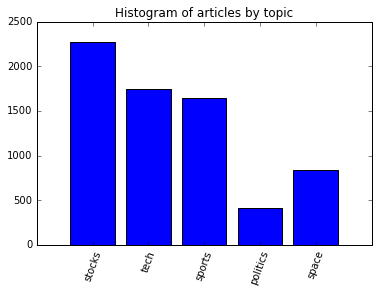

In [36]:
# Plot histogram of topics
plt.bar(list(set(target_)),counts, align='center')
plt.xticks(list(set(target_)),classes, rotation=70)
plt.title("Histogram of articles by topic")

In [44]:
list(set(target_))

[0, 1, 2, 3, 4]

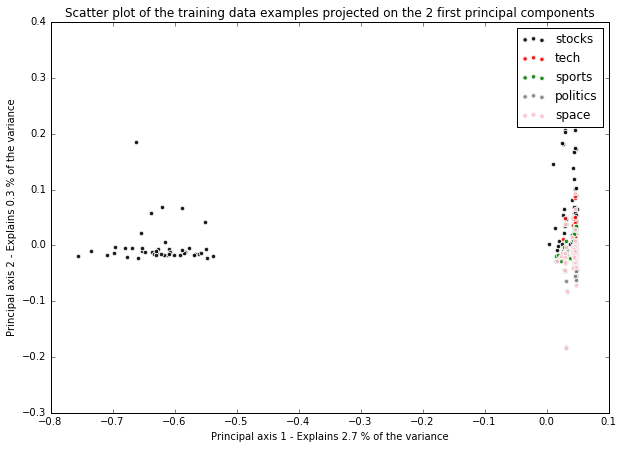

In [45]:
# plot first two principal components
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

data_ = normalize(data_)

pca = PCA(n_components=2).fit(data_)
data2D = pca.transform(data_)

# plt.scatter(data2D[:,0], data2D[:,1], c=target_)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1)
colors = ['black','red','green','grey', 'pink']
for color, label, class_ix in zip(
        colors, classes, list(set(target_))):
    ax.scatter(data2D[np.where(target_ == class_ix),0],
               data2D[np.where(target_ == class_ix),1],
               color=color, edgecolor='whitesmoke',
               linewidth='1', alpha=0.9, label=label)
    ax.legend(loc='best')
plt.title(
    "Scatter plot of the training data examples projected on the "
    "2 first principal components")
plt.xlabel("Principal axis 1 - Explains %.1f %% of the variance" % (
    pca.explained_variance_ratio_[0] * 100.0))
plt.ylabel("Principal axis 2 - Explains %.1f %% of the variance" % (
    pca.explained_variance_ratio_[1] * 100.0))
plt.show()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(vectors, target, 
                                                    test_size=0.2, random_state=1729)
print(X_train.shape, X_test.shape)

(5532, 121626) (1384, 121626)


In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

import pandas as pd

clf = MultinomialNB(alpha=1)
# clf = ExtraTreesClassifier(n_estimators = 25, criterion = "entropy", n_jobs=-1, 
#                            bootstrap=True, random_state=1729)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print("F-score: ", metrics.f1_score(y_test, pred, average='weighted'))
print("Accuracy: ", metrics.precision_score(y_test, pred, average='weighted'))
print("Confusion matrix:\n", pd.crosstab(y_test, pred, rownames=['True'], 
                                         colnames=['Predicted']))

F-score:  0.562605860568
Accuracy:  0.704724430508
Confusion matrix:
 Predicted    0    1    2  3   4
True                           
0          462    6    2  0   0
1          158  182   17  0   0
2          117   17  180  0   0
3           64    9    4  7   2
4          101   27   17  1  11


In [19]:
def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        print("%s: %s%s" % (category, '\n', ", ".join(np.unique(feature_names[top10])[0:20])))
        print()
        
# print ten most important words for each topic
show_top10(clf, vectorizer, le.classes_)

politics: 
2016, 2016 presidential, know, know 2016, need, need know, newsletter, presidential, presidential race, race

space: 
floor, like, mr, ms, new, people, room, said, square, time

sports: 
basketball, game, games, new, said, season, team, time, world, year

stocks: 
companies, fell, gains, investors, market, markets, oil, percent, rose, shares

tech: 
apple, companies, company, data, google, high, industry, like, new, technology



In [20]:
# end timer
print(time.time()-start_time, 'seconds')

153.74669814109802 seconds


In [21]:
# test the model on articles written before 2013-December-13
test = get_data(TOPICS = classes,
                ENDDATE = 20151213, NDOCS = [20])
test_data = [ x['snippet'] for x in test]
test_label = [ x['user_topic'] for x in test]

test_vectors = vectorizer.transform(test_data) 
test_target = le.transform(test_label)

print(test_vectors.shape, test_target.shape,'\n')
print("Number of unique words (features) across all docs: ", vectors.shape[1], '\n')
print("(docid, wordid) TFIDF", '\n')
print(vectors[0,])

Topics:  ['stocks', 'tech', 'sports', 'politics', 'space']
NPages:  [20, 20, 20, 20, 20]
Date range:  20151212 -> 20130904 

Total documents:  100
Started download...
stocks is done | 20/100
tech is done | 40/100
sports is done | 60/100
politics is done | 80/100
space is done | 100/100

Total documents returned:  100

Done in  6.181755065917969 seconds
(100, 121626) (100,) 

Number of unique words (features) across all docs:  121626 

(docid, wordid) TFIDF 

  (0, 20536)	0.248193483124
  (0, 4767)	0.248193483124
  (0, 82568)	0.248193483124
  (0, 108815)	0.248193483124
  (0, 97752)	0.248193483124
  (0, 20615)	0.237193559121
  (0, 119348)	0.474387118241
  (0, 8587)	0.237193559121
  (0, 45211)	0.218389064833
  (0, 4760)	0.210584494548
  (0, 82566)	0.181934682449
  (0, 108810)	0.214207087816
  (0, 97711)	0.159287329943
  (0, 20480)	0.24491444431
  (0, 119332)	0.263593925128
  (0, 8552)	0.169036841355


In [22]:
pred_test = clf.predict(test_vectors)
print("F-score: ", metrics.f1_score(test_target, pred_test, average='weighted'))
print("Accuracy: ", metrics.precision_score(test_target, pred_test, average='weighted'))
print("Confusion matrix:\n", pd.crosstab(test_target, pred_test, 
                                         rownames=['True'], colnames=['Predicted']))

F-score:  0.420919502438
Accuracy:  0.763796610169
Confusion matrix:
 Predicted   0   1   2  3  4
True                       
0          20   0   0  0  0
1           8  12   0  0  0
2           7   0  13  0  0
3           9   9   0  2  0
4          15   4   0  0  1


In [23]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_test, pred))
print("Completeness: %0.3f" % metrics.completeness_score(y_test, pred))
print("V-measure: %0.3f" % metrics.v_measure_score(y_test, pred))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(y_test, pred))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_test, pred, sample_size=1000))

Homogeneity: 0.226
Completeness: 0.350
V-measure: 0.274
Adjusted Rand-Index: 0.220
Silhouette Coefficient: 0.000


### Probabolistic Topic Modelling 
#### Latent Dirichlet Allocation

Example is [here](http://scikit-learn.org/dev/auto_examples/applications/topics_extraction_with_nmf_lda.html).

In [43]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

n_top_words = 10

lda = LatentDirichletAllocation(n_topics=3, 
                                max_iter=5,
                                # doc_topic_prior = 0.4,
                                # topic_word_prior = 0.6,
                                learning_method='online',
                                # learning_offset=50.,
                                random_state=1729)

lda.fit(vectors)

tf_feature_names = vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0:
today, presidential, race, news, know, need, newsletter, 2016, facebook, twitter
Topic #1:
angeles, los angeles, los, minister, article, station, international, misstated, fantasy, mutko
Topic #2:
com, org, par, officiated, bride, event, raptors, comedy, married, www



#### Non-negative Matrix Factorization

In [39]:
nmf = NMF(n_components=4, random_state=1
          #alpha=.01, l1_ratio=.5
         )

nmf.fit(vectors)
print_top_words(nmf, tf_feature_names, n_top_words)

Topic #0:
need know, know 2016, race today, news updates, updates facebook, today news, twitter draft, draft newsletter, 2016 presidential, facebook twitter
Topic #1:
mr, trump, mr trump, donald, donald trump, said, clinton, republican, party, sanders
Topic #2:
said, like, year, companies, time, people, years, percent, world, just
Topic #3:
york, new york, new, times, york times, times newsletter, follow new, follow, newsletter, york city



### LDAVis

https://github.com/bmabey/pyLDAvis

In [40]:
import pyLDAvis

# K - Number of topics
# W - number of terms in vocabulary
# D - Number of documents

# Prepare data
phi = [x/sum(x) for x in lda.components_] # topic-term distributions, KxW matrix 
theta = [x/sum(x) for x in lda.transform(vectors)] # document-topic distributions, DxK matrix 
doc_lengths = [len(x) for x in vectorizer.inverse_transform(vectors)] # number of tokens per doc [312,
voc = vocab
term_frequency = list(vectorizer.vocabulary_.values()) # freqs of terms in the corpus [8939, 5544

lda_data = {'topic_term_dists': phi, 
            'doc_topic_dists': theta,
            'doc_lengths': doc_lengths,
            'vocab': voc,
            'term_frequency': term_frequency} 

In [41]:
lda_vis = pyLDAvis.prepare(**lda_data)

In [42]:
# Visualize data
pyLDAvis.display(lda_vis)

In [29]:
np.array(phi).shape

(4, 121626)

In [30]:
np.array(theta).shape

(6916, 4)

In [31]:
lda.components_.shape

(4, 121626)